# **Adversarial Attack**

## Download the dataset

In [ ]:
# download the dataset
!gdown --id '14CqX3OfY9aUbhGp4OpdSHLvq2321fUB7' --output data.zip
# unzip the dataset
!unzip -qq -u data.zip
# check current file
!ls

Downloading...
From: https://drive.google.com/uc?id=14CqX3OfY9aUbhGp4OpdSHLvq2321fUB7
To: /content/data.zip
17.9MB [00:00, 83.8MB/s]
data  data.zip	sample_data


## Import the library

In [ ]:
import os
import torch

# read the dataset
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader

# read the image
from PIL import Image
import numpy as np

# import the pretrained model
import torchvision.models as models

# import the transformers
import torchvision.transforms as transforms

# loss function
import torch.nn.functional as F

import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # use GPU if available; otherwise CPU

## Read the Dataset

In [ ]:
# create a dataset inherited from the Dataset class
class AdverDataset(Dataset):
  def __init__(self, root, label, transforms):
    # the root directory of the photo
    self.root = root
    # the "label" from main()
    self.label = torch.from_numpy(label).long()
    # the "transforms" from the Attacker() model
    # for transforming the images into the desired format
    self.transforms = transforms
    # list for storing the file names
    self.fnames = []

    for i in range(200):
      self.fnames.append("{:03d}".format(i))

  def __getitem__(self, idx):
    # read the photo from the root directory
    img = Image.open(os.path.join(self.root, self.fnames[idx] + '.png'))
    # transform the image
    img = self.transforms(img)
    # the corresponding label for the img
    label = self.label[idx]
    return img, label

  def __len__(self):
    # 200 images in total
    return 200

## Create the Attacker Model

In [ ]:
class Attacker:
  """
  Create a Attacker to attack the original image.
  It combines the following functions:
  1) __init__(): initialize the model and normalize the img data then put them into the Dataset/DataLoader
  2) fgsm_attack(): perform FGSM to add the noise to the image
  3) attack(): attack all the images in the DataLoader to determine if it's success
  """
  def __init__(self, img_dir, label):
    """
    This "__init__()" function do the following tasks:
    1) load the "pretrained" model
    2) nomalize the image
    3) put the input image into the Dataset and DataLoader
    """
    # load the pretrained model
    self.model = models.vgg16(pretrained=True)
    self.model.cuda() # GPU
    self.model.eval() # set the model to evaluation mode
    self.mean = [0.485, 0.456, 0.406] # per PyTorch doc
    self.std = [0.229, 0.224, 0.225] # per PyTorch doc

    # normalize the image to [0, 1] with mean as 0 and variance as 1
    self.normalize = transforms.Normalize(self.mean, self.std, inplace=False)
    transform = transforms.Compose(
        [
         transforms.Resize((224, 224), interpolation=3),
         transforms.ToTensor(),
         self.normalize
        ]
    )

    # read the dataset by AdverDataset class
    self.dataset = AdverDataset('./data/images', label, transform)
    self.loader = torch.utils.data.DataLoader(
        self.dataset,
        batch_size = 1,
        shuffle = False
    )

  # FGSM Attack
  def fgsm_attack(self, image, epsilon, data_grad):
    # find the sign(direction) of the gradient
    sign_data_grad = data_grad.sign()
    # add the noise to the image on the sign of the gradient times epsilon
    perturbed_image = image + epsilon * sign_data_grad
    return perturbed_image
  
  # perform attack on the image iteratively
  def attack(self, epsilon):
    # a list for storing the successfully attacked images
    adv_examples = []
    wrong, fail, success = 0, 0, 0
    
    for (data, target) in self.loader:
      data, target = data.to(device), target.to(device)
      data_raw = data
      data.requires_grad = True # revise (attack) the image by gradient update

      # get the correpondeing class of the input image
      output = self.model(data) # (values, indices)
      init_pred = output.max(1, keepdim=True)[1] # get the "indices" from the 2nd element of output

      # not going to attack if the wrong class prediction
      if init_pred.item() != target.item():
        wrong += 1
        continue
      
      # perform FGSM attack if the class prediction is correct
      loss = F.nll_loss(output, target) # loss
      self.model.zero_grad() # zero the gradient
      loss.backward()
      data_grad = data.grad.data # get the gradient of the image
      perturbed_data = self.fgsm_attack(data, epsilon, data_grad) # FGSM attack

      # test the perturbed image
      output = self.model(perturbed_data)
      final_pred = output.max(1, keepdim=True)[1]

      # fail to attack
      if final_pred.item() == target.item():
        fail += 1

      else:
        # attack successfully
        success += 1
        # save the successfully attacked image
        if len(adv_examples) < 5:
          adv_ex = perturbed_data * torch.tensor(self.std, device=device).view(3, 1, 1) + torch.tensor(self.mean, device=device).view(3, 1, 1)
          adv_ex = adv_ex.squeeze().detach().cpu().numpy()
          data_raw = data_raw * torch.tensor(self.std, device=device).view(3, 1, 1) + torch.tensor(self.mean, device=device).view(3, 1, 1)
          data_raw = data_raw.squeeze().detach().cpu().numpy()
          adv_examples.append((init_pred.item(), final_pred.item(), data_raw, adv_ex))

    final_acc = (fail / (wrong + success + fail))

    print("Epsilon: {}\tTest Accuracy: {} / {} = {}\n".format(epsilon, fail, len(self.loader), final_acc))
    return adv_examples, final_acc

## Perform Attack and Display the Attack Accuracy

In [ ]:
if __name__ == '__main__':
  # load the labels
  df = pd.read_csv('./data/labels.csv')
  df = df.loc[:, 'TrueLabel'].to_numpy()
  label_name = pd.read_csv('./data/categories.csv')
  label_name = label_name.loc[:, 'CategoryName'].to_numpy()

  # new a Attacker class
  attacker = Attacker('./data/images', df)
  # epsilons
  epsilons = [0.1, 0.01]

  accuracies, examples = [], []

  # perform attack and save the accuracies
  for eps in epsilons:
    ex, acc = attacker.attack(eps)
    examples.append(ex)
    accuracies.append(acc)

Epsilon: 0.1	Test Accuracy: 6 / 200 = 0.03

Epsilon: 0.01	Test Accuracy: 54 / 200 = 0.27



## Display the Attacked Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


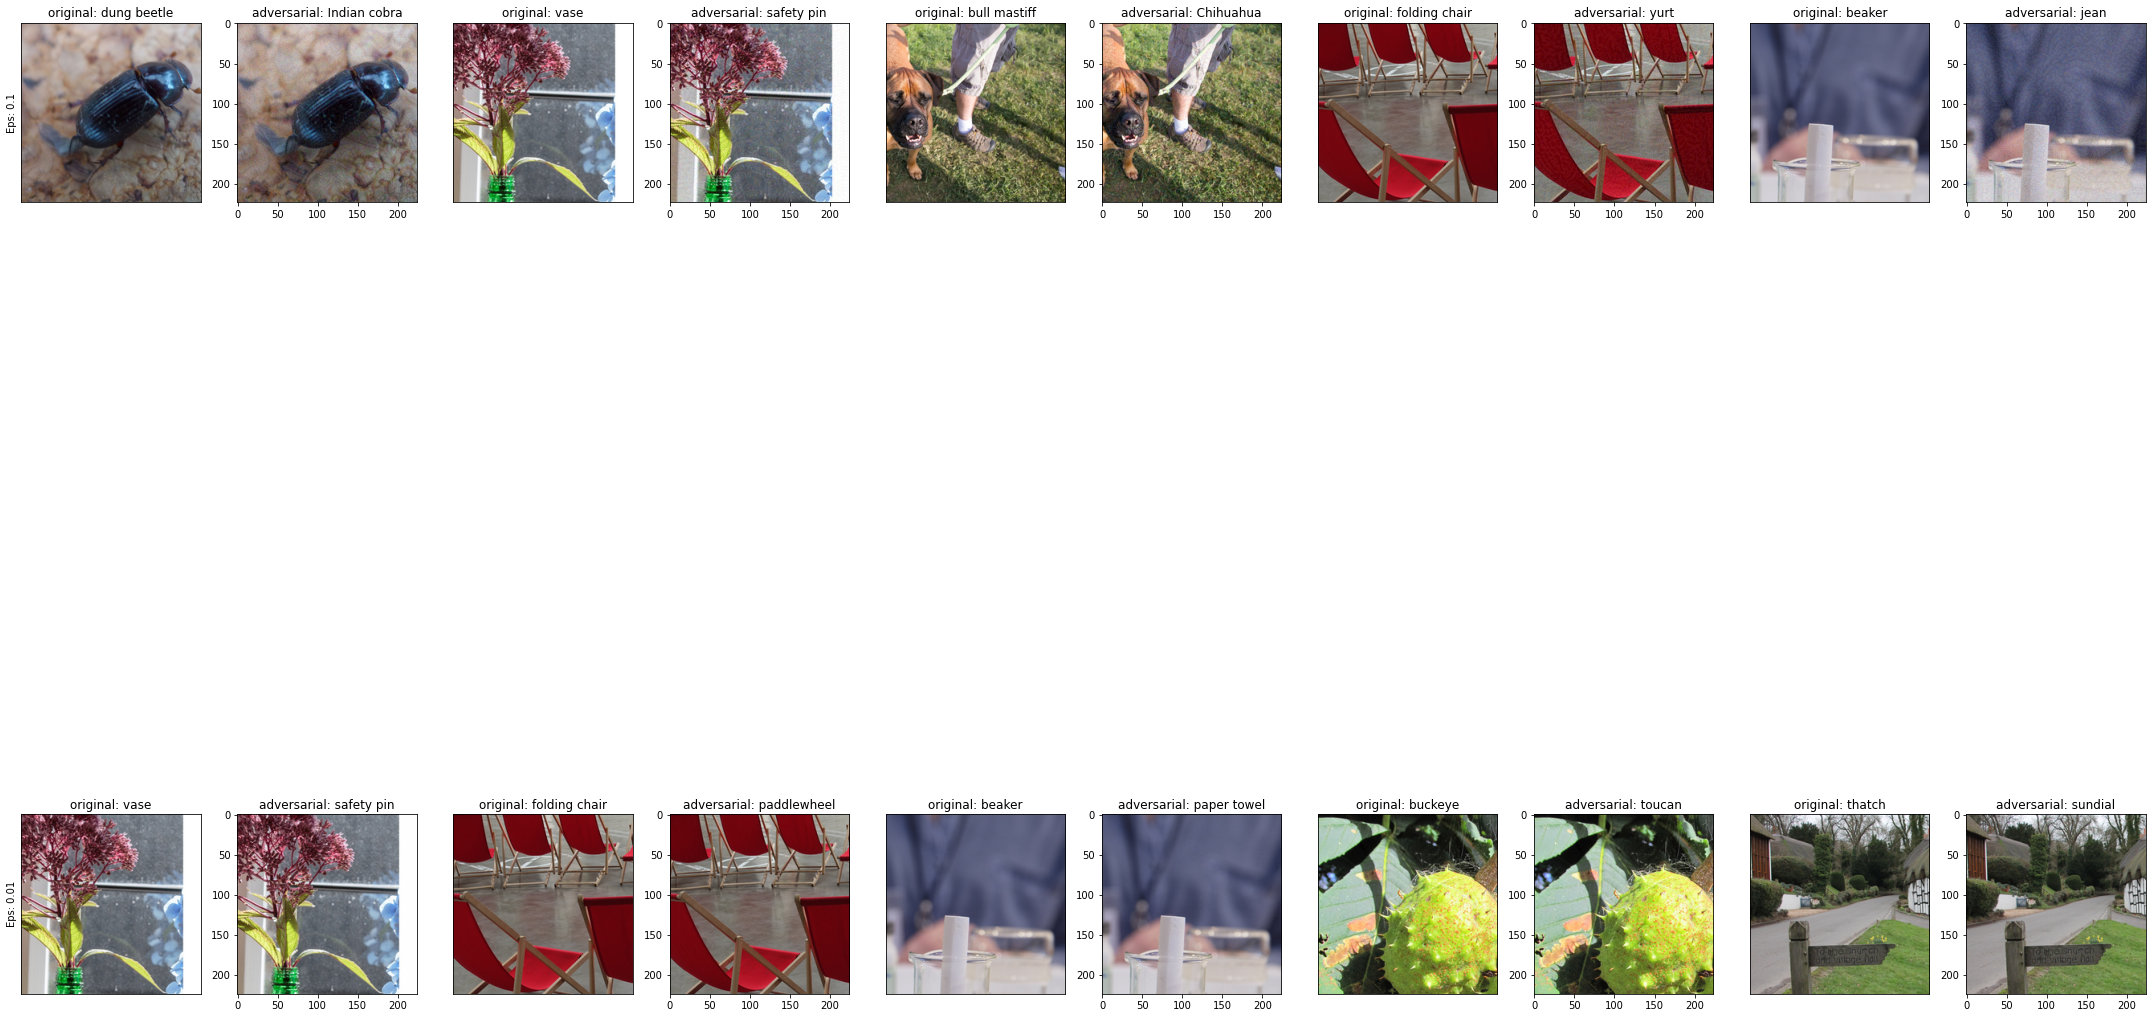

In [ ]:
cnt = 0
plt.figure(figsize=(30, 30))
for i in range(len(epsilons)):
  for j in range(len(examples[i])):
    cnt += 1
    plt.subplot(len(epsilons), len(examples[0])*2, cnt) # determine the plot location
    plt.xticks([], [])
    plt.yticks([], [])

    if j == 0: # the 1st img
      plt.ylabel('Eps: {}'.format(epsilons[i], fontsize=14))
    
    orig, adv, orig_img, ex = examples[i][j]

    # plot the original image
    plt.title('original: {}'.format(label_name[orig].split(',')[0]))
    orig_img = np.transpose(orig_img, (1, 2, 0))
    plt.imshow(orig_img)
    cnt += 1

    # plot the attacked image
    plt.subplot(len(epsilons), len(examples[0])*2, cnt) # determine the plot location
    plt.title('adversarial: {}'.format(label_name[adv].split(',')[0]))
    ex = np.transpose(ex, (1, 2, 0))
    plt.imshow(ex)
plt.tight_layout()
plt.show()